# Part 4: Transfer

Deep neural networks learn representations of data that can be helpful for related but different tasks than that for which they were originally trained. This is a valuable property, because it suggests that some of the representation learning can be **transferred** to a different related task.

In this part of the assignment, you will load a pre-trained neural network originally trained for one image recognition task and will apply and fine tune that model for a related but different image recognition task on a different dataset, all using PyTorch. Specifically, we will use a pretrained ResNet model (a convolutional neural network with a residual component) to classify 32 by 32 pixel color images of animals, automobiles, planes, and ships (10 classes in total).

**Learning objectives.** You will:
1. Apply a pre-trained ResNet model for a related but different image recognition task by retraining the final decision layer.
2. Fine tune a pre-trained model to improve model performance on a new task.
3. Evaluate different learning hyperparameters and model architecture choices by evaluating validation performance
4. Accelerate neural network training and inference using a graphics processing unit (GPU) with software support in PyTorch.
5. Compute and visualize gradient class activation maps as model saliancy visualizations
6. Consider the role of interpretability and explainability in machine learning models

While it is possible to complete this part using CPU compute, it may be very slow. To accelerate your training, consider using GPU resources such as `CUDA` through the CS department cluster. Alternatives include Google colab or local GPU resources for those running on machines with GPU support.

The following code imports relevant PyTorch modules, downloads the dataset, splits into a train, validation, and test dataset, and prepares PyTorch dataloaders for batching.

In [1]:
# Run but DO NOT MODIFY this code

# Import libraries
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
train_data = datasets.CIFAR10(root="data", train=True, download=True, transform=ToTensor())
train_set, val_set = random_split(train_data, [0.8, 0.2])
test_data = datasets.CIFAR10(root="data", train=False, download=True, transform=ToTensor())

# Prepare DataLoaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:02<00:00, 61766793.56it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


The following code then visualizes some random examples of the training data.

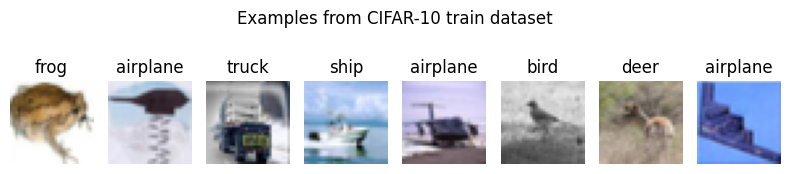

In [2]:
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog",
"horse", "ship", "truck"]

# Function to show an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# Get some random training images
dataiter = iter(torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True))
images, labels = next(dataiter)

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(1, 8, figsize=(8, 2))
fig.suptitle('Examples from CIFAR-10 train dataset', fontsize=12)

# Plot 8 images
for i, ax in enumerate(axs.flat):
    ax.imshow(np.transpose(images[i].numpy(), (1, 2, 0)))
    ax.set_title(f"{classes[labels[i]]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

## Task 1

The following code imports a pretrained ResNet model that was trained to classify color images on the ImageNet dataset. The images in that dataset represent 1,000 possible classes. By contrast, the images in our dataset are classified into one of just 10 classes.

Unsurprisingly, you will find that you cannot directly apply the ResNet model to prediction on our CIFAR-10 dataset. However, we can achieve surprising performance by **only changing the output layer** of the model, leaving all parameters prior to the final layer unchanged (setting `requires_grad = False` for an element of `model.parameters()` should accomplish this freezing). Freeze the model parameters and replacing the final `.fc` layer with a fully connected [linear layer](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) with just 10 output units.

In [5]:
from torchvision import models
import torch.nn as nn
model = models.resnet18(pretrained=True)
for x in model.parameters():
    x.requires_grad=False
model.fc=nn.Linear(model.fc.in_features,10)

## Task 2

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to optimize the parameters of **the output layer only** (which should be what happens if you completed task 1 correctly) on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). You may use Tensorboard but are not required to do so.

You should be able to achieve a validation accuracy of 40% or better without changing any model parameters except the last layer, though you may need to experiment with the training hyperparameters to accomplish this. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [9]:
gpu=torch.device("cuda")
model = model.to(gpu)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=.025)
epochs=5
for epoch in range(epochs):
  for batch,(x,y) in enumerate(train_loader):
    x=x.to(gpu)
    y=y.to(gpu)
    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    val_loss=0;
    correct=0;
    for(x,y) in val_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      val_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/len(val_loader.dataset)
    print(f"Epoch num:{epoch}")
    print(f"Validation loss:{val_loss}")
    print(f"Validation accuracy:{accuracy}\n")

with torch.no_grad():
    test_loss=0;
    correct=0;
    for(x,y) in test_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      test_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/len(test_loader.dataset)
    print(f"Test loss:{val_loss}")
    print(f"Test accuracy:{accuracy}\n")

Epoch num:0
Validation loss:253.02382826805115
Validation accuracy:0.4424

Epoch num:1
Validation loss:255.92841637134552
Validation accuracy:0.4339

Epoch num:2
Validation loss:259.66613936424255
Validation accuracy:0.4267

Epoch num:3
Validation loss:256.81819903850555
Validation accuracy:0.4304

Epoch num:4
Validation loss:253.4856505393982
Validation accuracy:0.4447

Test loss:253.4856505393982
Test accuracy:0.4488



I used a learning rate of .025, 5 epochs, and cross entropy loss to train the model. I achieved approximately 45% accuracy on the test data.

## Task 3

We can achieve a higher level of performance by **fine-tuning** the entire pre-trained model on the new task. Start with the original pretrained ResNet model and replace the output layer as before, but this time **do not** freeze any of the other parameters.

Use [minibatch stochastic gradient descent](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) to fine tune the parameters (that is, normal training, but usually with a relatively small learning rate) on the training data by optimizing the [cross entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Evaluate and report the validation accuracy (accuracy on the heldout validation set) at the end of each epoch of training (optionally, you may wish to report the training or validation [loss](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html)). You may use Tensorboard but are not required to do so.

You should be able to achieve a validation accuracy of 75% or better, though you may need to experiment with the training hyperparameters to accomplish this. When you are satisfied, also evaluate and report the accuracy of your model on the heldout test data.

Briefly list in English all of the hyperparameters you chose for the training of your final model.

In [12]:
model = models.resnet18(pretrained=True)
model.fc=nn.Linear(model.fc.in_features,10)
gpu=torch.device("cuda")
model = model.to(gpu)
loss_fn=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=.005)
epochs=5
for epoch in range(epochs):
  for batch,(x,y) in enumerate(train_loader):
    x=x.to(gpu)
    y=y.to(gpu)
    y_pred=model(x)
    loss=loss_fn(y_pred,y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

  with torch.no_grad():
    val_loss=0;
    correct=0;
    for(x,y) in val_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      val_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/len(val_loader.dataset)
    print(f"Epoch num:{epoch}")
    print(f"Validation loss:{val_loss}")
    print(f"Validation accuracy:{accuracy}\n")
with torch.no_grad():
    test_loss=0;
    correct=0;
    for(x,y) in test_loader:
      x=x.to(gpu)
      y=y.to(gpu)
      y_pred=model(x)
      test_loss+=loss_fn(y_pred,y).item()
      correct+=(y_pred.argmax(1)==y).type(torch.float).sum().item()
    accuracy=correct/len(test_loader.dataset)
    print(f"Test loss:{val_loss}")
    print(f"Test accuracy:{accuracy}\n")

Epoch num:0
Validation loss:147.68403315544128
Validation accuracy:0.6712

Epoch num:1
Validation loss:127.94248160719872
Validation accuracy:0.7166

Epoch num:2
Validation loss:120.6230785548687
Validation accuracy:0.7404

Epoch num:3
Validation loss:118.89010816812515
Validation accuracy:0.7495

Epoch num:4
Validation loss:118.31734281778336
Validation accuracy:0.7591

Test loss:118.31734281778336
Test accuracy:0.755



I achieved a test accuracy of 75.5%. I used a learning rate of .005, 5 epochs, and cross entropy loss to train the model. 

## Task 4

Though they can achieve impressive performance, it can be very challenging to make sense of how deep learning models make predictions. One common approach to analyzing deep convolutional neural networks for image recognition tasks is to compute a saliancy map, a heat map over an image input that highlights the regions most contributing activation scores to the decision layer of the model. 

For example, the [The Bishop Deep Learning Book](https://www.bishopbook.com/), Section 10.3.3, describes the Gradient Class Activation Map (Grad-CAM) method introduced by [Selvaraju and all 2016](https://arxiv.org/abs/1610.02391). Given an image and label, this technique computes the derivatives of the score for the label's output unit with respect to the weights of (usually) the last convolutional layer. These are used to compute a weighted average of the feature maps of the final convolutional layer, which is then upsampled and projected as a heatmap onto the original image. Conceptual at a high level, the idea is that this estimates the regions of the image that provide significant contributions to the activation for the given output unit.


Below, we install and import the `pytorch-grad-cam` package, which you can [see on Github here](https://github.com/jacobgil/pytorch-grad-cam/tree/master). Compute and visualize the Grad-CAM for the **original** pretrained (**not** fine-tuned) ResNet model for each of the three images in `cat_images` (`tuxedo_cat.jpg`, `kittens.jpg`, and `dog_cat.jpg`), each with respect to the `cat` label. 

We recommend reviewing the [introductory documentation here](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html) to familiarize yourself with the usage of `GradCAM`, especially [this minimal example](https://jacobgil.github.io/pytorch-gradcam-book/introduction.html#using-from-code-as-a-library) which also uses a ResNet model (a slightly larger one than used here). Note also the use of `ClassifierOutputTarget(281)`; 281 is the index corresponding to `cat` in the imagenet dataset on which ResNet was trained, and that's what you'll be looking for in these example images as well, so you can use it in the same way.

You will probably need to install the grad-cam package. To do so, uncommonent and run the following cell.

In [ ]:
#pip install grad-cam

Now you should be able to import from the `pytorch_grad_cam` package.

In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

True
(224, 224)


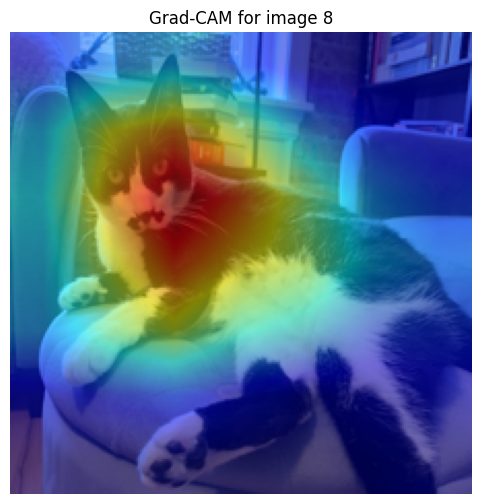

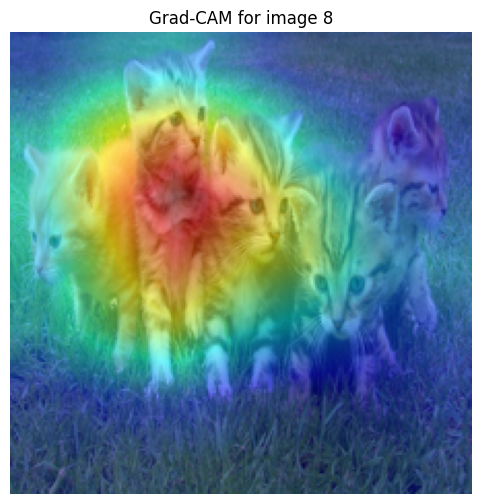

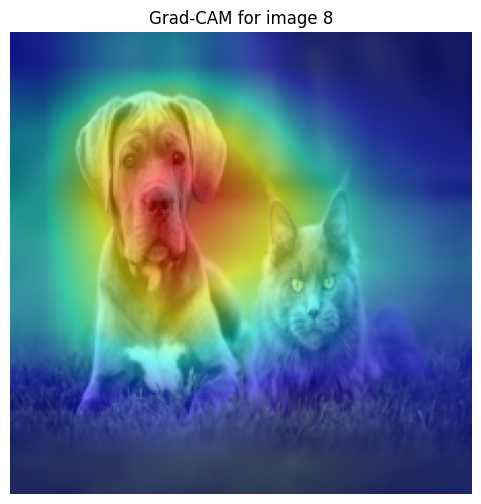

In [48]:
from PIL import Image
import os
from torchvision import models, transforms
tuxedo_cat = Image.open('cat_images/tuxedo_cat.jpg')
kittens = Image.open('cat_images/kittens.jpg')
dog_cat= Image.open('cat_images/dog_cat.jpg')
cats=[]
cats.append(tuxedo_cat)
cats.append(kittens)
cats.append(dog_cat)

model = models.resnet18(pretrained=True)
target_layers = [model.layer4[-1]]
model.eval()
cam = GradCAM(model=model, target_layers=target_layers)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
targets = [ClassifierOutputTarget(281)]

print(test_img.is_leaf)
grayscale_cam = cam(input_tensor=test_img, targets=targets)[0]
print(grayscale_cam.shape)
for img in cats:
    img_tensor = preprocess(img).unsqueeze(0)
    grayscale_cam = cam(input_tensor=img_ten, targets=targets)[0]
    img_np = np.array(img.resize((224, 224)))/255.0
    cam_image = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(6, 6))
    plt.imshow(cam_image)
    plt.title(f"Grad-CAM for image {i+1}")
    plt.axis('off')
    plt.show()
    

*Optional Extra challenge* If you would like an extra challenge for your PyTorch programming, you could try implementing Grad-CAM yourself instead of using the library. The main challenge is that some of the derivatives you need for computing the feature map weights are not stored by default because they are not leaf nodes in the PyTorch computational graph. Common approaches to address this involve modifying the `forward` method, potentially registering a [Pytorch `hook`](https://pytorch.org/docs/stable/generated/torch.Tensor.register_hook.html). Don't try this until you have finished the rest of the assignment, and not that it is not for points.

## Task 5

Not everyone agrees that saliency maps like those you computed above are necessarily helpful for understanding machine learning models. Read at least Sections 1-2 (about 5 pages) of [Dr. Rudin](https://users.cs.duke.edu/~cynthia/)'s [2019 Nature perspective article](https://arxiv.org/abs/1811.10154). Then write 1-2 paragraphs in response to each of the following two questions.

1. Summarize the difference between **interpretable** and **explainable** machine learning models as described in the article.
2. Do you think that saliency maps such as from Grad-CAM are helpful for explaining image recognition models? Briefly explain why or why not.

Interpretable models are designed to be understandable, showing clear cause and effect, and ensure outputs are logical. An example of this would be a decision tree. On the other hand, explainable models are very robust internally, making it hard to show how it is exactly working. I think saliency maps could be helpful in showing what in the input is important, but doesn't really explain how the model works. Just because I known that a model heavily relies on the pixels around a dogs face to decide a picture is a dog doesn't tell me how the model came to that conclusion. For someone with no knowledge of AI, they could be helpful, but for someone who wants a more in-depth look, they'd need to look at the architecture itself.